**@author: James V. Talwar**

# MHC-I AI Status and PRS: Discovery and Validation Sets

**About:** This notebook provides the code needed to generate Figure 2 panels B and C and Supplementary Figure 11 from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses investigated independent and interactive effects between MHC-I AI allele carrier status and melanoma PRS developed by *Gu et al.* in skin cutaneous melanoma (SKCM) cases in TCGA (Discovery) and an independent validation set.

## 1. Import Packages; Load Data

In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import tqdm
from scipy.stats import spearmanr
from scipy.stats import pearsonr

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger()
console = logging.StreamHandler()
logger.addHandler(console)

In [3]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [4]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

Load in SKCM TCGA PRS SNPs that were able to be extracted:

In [5]:
tcgaSNPs = pd.read_csv("../GenotypeData/SKCM_TCGA_Risk_SNPs.vcf", sep = "\t", skiprows=26)

Load in validation cohort subset with sufficient SNP data for PRS construction (UKBB):

In [6]:
ukbbRelevantIDs = pd.read_csv("../GenotypeData/UKBB.tsv", sep = "\t", index_col=0)
ukbbRelevantIDs["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in ukbbRelevantIDs.iterrows()]

In [7]:
#Melanoma PRS SNPs for the full UKBB
ukbb = pd.read_csv("../GenotypeData/ukbb.205.raw", sep = "\t") 

In [8]:
filteredUKBB = ukbb[ukbb.ids.isin(set(ukbbRelevantIDs.index))] #Subset down to the melanoma UKBB individuals
del ukbb

Load in PRS SNP effect csv with the corrected SNP locations (many are off by 1 as reported in the Gu Melanoma PRS paper):

In [9]:
prsDF = pd.read_csv("../Data/Gu_Melanoma_PRS/PRS_Weights.tsv", sep = "\t", index_col = 0)
prsDF.head()

,Chr,Loc,Close genes in Genome Browser,"Close genes reported in Law et al., 2015",Weight#,Ref allele for the weight,CorrectedLocs
rs17416005,1.0,10761758.0,CASZ1,NaN,-0.00930,A,10761759.0
rs4655048,1.0,22668770.0,RP11-415K20.1|AL591122.20,NaN,-0.00460,T,22668771.0
rs6679026,1.0,78619511.0,RNFT1P2|RP11-472F19.2|GIPC2,NaN,-0.01700,T,78619512.0
rs11577235,1.0,114113339.0,MTND5P20|RP11-473L1.1|MAGI3,NaN,-0.01400,T,114113340.0
rs491313,1.0,114639042.0,SYT6,NaN,0.00045,C,114639043.0


Load in PRS SNP Summary with both *effect* and *other* alleles (and coefficients for other non-optimal PRS constructed in their original paper):

In [10]:
orData = pd.read_excel("../Data/Gu_Melanoma_PRS/Gu_Melanoma_PRS_Supplementary_Table_6.xlsx")
orData.columns = orData.loc[0, :]
orData = orData.drop([0,205, 206,207,208])

newFirstColumn = list()
for el in orData.SNP:
    newFirstColumn.append(el.strip("*"))

orData.SNP = newFirstColumn
orData.index = orData.SNP
orData = orData.drop(columns = ["SNP"])
orData.head()

,Chr,Loc,effect_allele,other_allele,MAF_genomel,bet_genomel,P-genomel,MAF_medit,beta_medit,P-medi,P-beta-diff
SNP,,,,,,,,,,,
rs17416005,1,10761759,A,G,0.279908,-0.091374,0.000015,0.328704,-0.040601,0.387738,0.490981
rs4655048,1,22668771,T,C,0.223976,-0.090374,0.000041,0.162255,-0.043438,0.454048,0.599436
rs6679026,1,78619512,T,C,0.110214,-0.132128,0.000009,0.097625,-0.006831,0.923434,0.212579
rs11577235,1,114113340,T,C,0.074738,-0.150454,0.000017,0.051165,-0.035749,0.716677,0.437082
rs491313,1,114639043,C,T,0.158052,0.090693,0.000092,0.149199,0.093921,0.111215,0.79685


## 2. TCGA: Data Processing, Formatting, PRS Generation, Statistical Analyses, and Figures

**SNP processing and PRS construction:** 

Preprocess TCGA SNPs to remove duplicates:

In [11]:
whichIsWhich = defaultdict(str) #dictionary mapping LOC to ALT+REF alleles
indexesToKeep = set()

for i,row in tcgaSNPs.iterrows():
    if row["POS"] in whichIsWhich: #should handle the incorrect duplicate issue for one SNP (188112554)
        continue 
    whichIsWhich[row["POS"]] = row["ALT"] + row["REF"]
    indexesToKeep.add(i) 

In [12]:
print("Pre-duplicate removal PLINK returned {} PRS SNPs.".format(tcgaSNPs.shape[0]))
tcgaSNPs = tcgaSNPs.drop([i for i in tcgaSNPs.index if i not in indexesToKeep], axis = 0)
print("Post-duplicate filtering returns {} PRS SNPs for PRS construction.".format(tcgaSNPs.shape[0]))

Pre-duplicate removal PLINK returned 191 PRS SNPs.
Post-duplicate filtering returns 190 PRS SNPs for PRS construction.


Define a funciton to filter SNPs to correctly map effect SNPs to alt/ref allele:

In [13]:
def Convert(plinkymonGo):
    numAltAlleles = 0
    for alleles in plinkymonGo.split("/"):
        numAltAlleles += int(alleles)
    return numAltAlleles

Create data structure mapping SKCM TCGA patients to SNPs to number of alternate alleles:

In [14]:
patientToSNPs = defaultdict(lambda: defaultdict(int))
for i,row in tcgaSNPs.iterrows():
    for j in tcgaSNPs.columns[9:]:
        patientToSNPs[j.split("_")[0]][row["POS"]] = Convert(row[j]) #number of alt SNPs

*Sanity Check*: Ensure no SNP is homozygous

In [15]:
tcgaSNPsToCount = defaultdict(set)
for k,v in patientToSNPs.items():
    for snp, count in v.items():
        tcgaSNPsToCount[snp].add(count)

for snp,v in tcgaSNPsToCount.items(): #checks if any of these SNP positions are homozygous
    if len(v) == 1:
        print(snp)
        print(v)

Align SNPs to the PRS effect SNP:

In [16]:
numMissing = set()
numGood = 0
haveToBeSwapped = set()
for i,row in orData.iterrows():
    if row["Loc"] not in whichIsWhich:
        numMissing.add(row["Loc"])
        continue
        
    elif whichIsWhich.get(row["Loc"]) != row["effect_allele"] + row["other_allele"]:
        haveToBeSwapped.add(row.Loc)
        print("SNP Loc {} PRS Effect/Other orientation: {}".format(row["Loc"], row["effect_allele"] + row["other_allele"]))
        print("SNP Loc {} TCGA orientation: {}".format(row["Loc"], whichIsWhich.get(row["Loc"])))
        
    else:
        numGood +=1
        
print("\nMissing SNPs: {}".format(len(numMissing)))
print("Good SNPs: {}".format(numGood))
print("There are {} SNPs that have the effect SNP as the Reference SNP. They are found at positions: ".format(len(haveToBeSwapped)))
print(haveToBeSwapped)

SNP Loc 125073958 PRS Effect/Other orientation: GA
SNP Loc 125073958 TCGA orientation: AG
SNP Loc 42988088 PRS Effect/Other orientation: CA
SNP Loc 42988088 TCGA orientation: AC

Missing SNPs: 14
Good SNPs: 188
There are 2 SNPs that have the effect SNP as the Reference SNP. They are found at positions: 
{42988088, 125073958}


In [17]:
tcgaPRS = defaultdict(float)

for k,v in patientToSNPs.items(): #key = patientID; value = dictionary mapping positions to Num alt alleles
    localCounter = 0 #counter to ensure only 2 SNPs have PRS oriented in the swapped direction from PLINK calls
    numOperations = 0 #counter to ensure PRS is comprised of the all (190) PRS SNPs that were able to be extracted from the TCGA
    for i,row in prsDF.iterrows():
        if row["CorrectedLocs"] not in whichIsWhich:
             continue        

        if row["CorrectedLocs"] in haveToBeSwapped:           
            tcgaPRS[k] += (2-v[row["CorrectedLocs"]])*row["Weight#"]
            localCounter += 1  
            numOperations += 1
        else:
            tcgaPRS[k] += v[row["CorrectedLocs"]]*row["Weight#"]
            numOperations += 1
    if (localCounter != len(haveToBeSwapped)) or (numOperations != tcgaSNPs.shape[0]):
        raise ValueError("PRS Construction Issue - inconsistent number of swaps/unexpected number of SNPs for TCGA PRS construction")

Concatenate constructed PRS with TCGA summary DF:

In [18]:
prsToBeAdded = list()
dropTheNonMatchers = list() #those individuals in the SKCM TCGA for which PRS SNPs could not be extracted

for i, row in tcgaSummary.iterrows():
    if i not in tcgaPRS:
        dropTheNonMatchers.append(i)
        continue
    prsToBeAdded.append(tcgaPRS[i])
    
tcgaSummary = tcgaSummary.drop(dropTheNonMatchers, axis = 0)
tcgaSummary = tcgaSummary.assign(PRS = prsToBeAdded)

### Figure generation and statistical analyses:

Do PRS correlate with age of diagnosis in the TCGA?

In [19]:
rho, pSpearman = spearmanr(tcgaSummary.PRS, tcgaSummary.Age)
r, pPearson = pearsonr(tcgaSummary.PRS, tcgaSummary.Age)

logging.info(f"TCGA: PRS-Age at Diagnosis Spearman Correlation: rho = {rho}   p = {pSpearman}")
logging.info(f"TCGA: PRS-Age at Diagnosis Pearson Correlation: r = {r}   p = {pPearson}")

TCGA: PRS-Age at Diagnosis Spearman Correlation: rho = -0.15101003529257045   p = 0.0016253317479697123
TCGA: PRS-Age at Diagnosis Pearson Correlation: r = -0.15119470977781618   p = 0.0016037670052186728


Do PRS associate significantly with an earlier age of diganosis in the TCGA?

In [20]:
model_interaction = smf.ols(formula='Age ~ PRS', data=tcgaSummary).fit() 
summary = model_interaction.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.9795,1.015,60.078,0.000,58.984,62.974
PRS,-7.4990,2.362,-3.175,0.002,-12.141,-2.857


In [21]:
model_interaction.pvalues

Intercept    1.428147e-211
PRS           1.603767e-03
dtype: float64

Do melanoma PRS and MHC-I AI allele genotype interact?

In [22]:
model_interaction = smf.ols(formula='Age ~ PRS*HasProtection', data=tcgaSummary).fit() 
summary = model_interaction.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,58.0761,1.323,43.903,0.000,55.476,60.676
HasProtection[T.True],6.8313,2.031,3.363,0.001,2.839,10.824
PRS,-3.6846,3.062,-1.203,0.229,-9.702,2.333
PRS:HasProtection[T.True],-9.1242,4.735,-1.927,0.055,-18.432,0.183


**Figure 2B:**

(17.0, 93.0)

<Figure size 1296x1296 with 0 Axes>

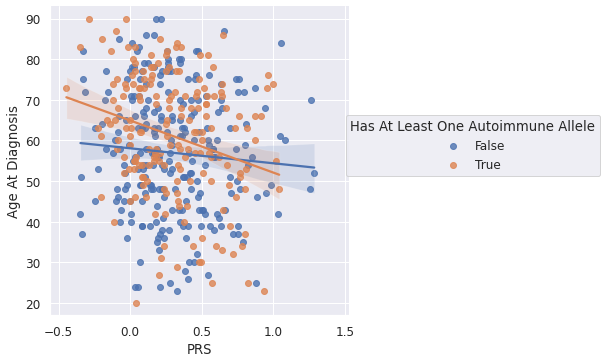

In [23]:
sns.set(font_scale = 1.1)
plt.figure(figsize=(18,18))
g = sns.lmplot(data = tcgaSummary, y="Age", x = "PRS", hue="HasProtection", legend_out=False) #, markers=["s", "o"]

plt.legend(bbox_to_anchor=(1.86, .43), title='Has At Least One Autoimmune Allele', loc='lower right') #, labels=['True', 'False'])
plt.ylabel("Age At Diagnosis")
plt.xlim(-0.56, 1.53)
plt.ylim(17,93)

**Supplementary Figure 11A:** Histogram of PRS stratified across individuals with and without MHC-I AI alleles (TCGA)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

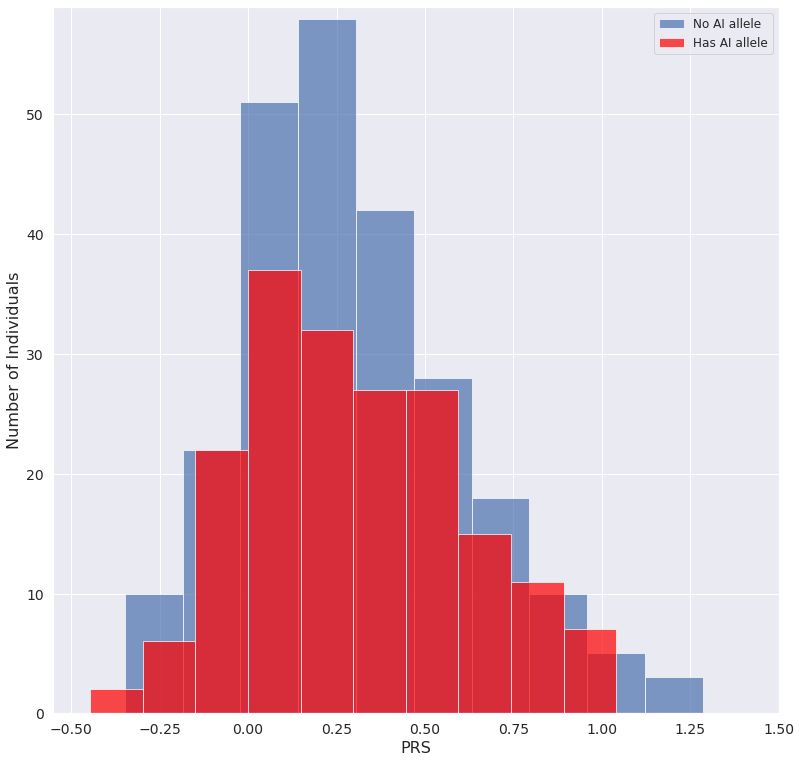

In [24]:
plt.figure(figsize=(13,13))
plt.hist(tcgaSummary[(tcgaSummary["HasProtection"]==False)].PRS, alpha = 0.7, label="No AI allele")
plt.hist(tcgaSummary[(tcgaSummary["HasProtection"])].PRS, alpha = 0.7, label = "Has AI allele", color= "red")
plt.legend()
plt.xlabel("PRS", fontsize = 16)
plt.ylabel("Number of Individuals", fontsize = 16)
plt.xlim(-0.55, 1.5)
plt.ylim(0,59)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)

**Supplementary Figure 11B:** Box + swarm plots stratifying PRS across individuals with and without MHC-I AI alleles (TCGA)



Statistic = -0.002, p= 0.999
Same distribution (fail to reject H0)


(array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
         1.5 ,  1.75]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

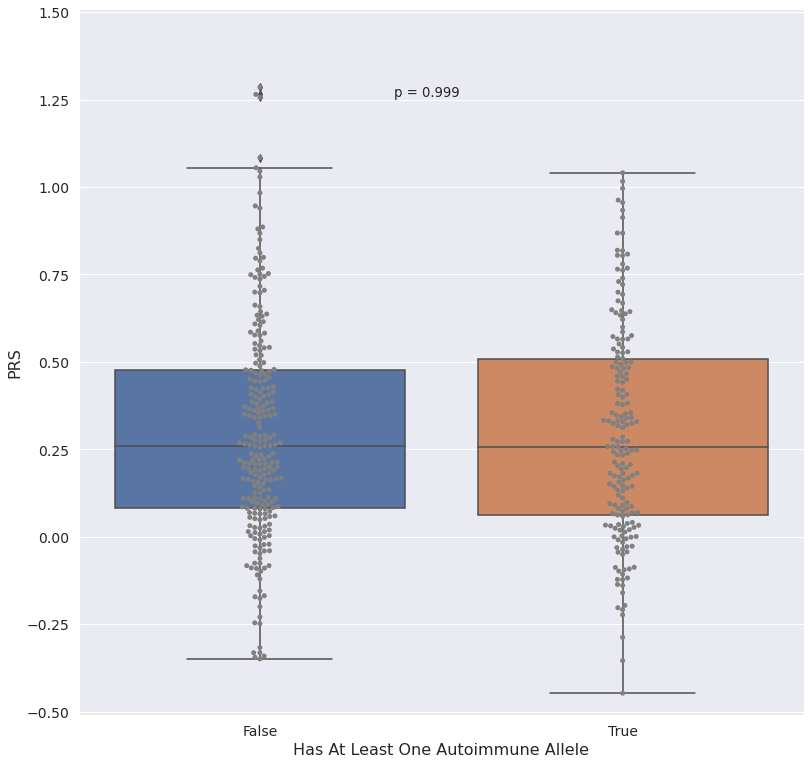

In [25]:
stat,pPRSDiff = ttest_ind(tcgaSummary[(tcgaSummary["HasProtection"])].PRS, tcgaSummary[(tcgaSummary["HasProtection"]==False)].PRS)
print("\n")
print('Statistic = %.3f, p= %.3f' % (stat, pPRSDiff))

alpha = 0.05
if pPRSDiff > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

plt.figure(figsize=(13,13))
sns.boxplot(data = tcgaSummary, y = "PRS", x="HasProtection")
sns.swarmplot(data = tcgaSummary, y = "PRS", x="HasProtection", color = 'grey')

plt.text(0.37, 1.26, "p = {0:.3f}".format(pPRSDiff)) #(T-Test)
plt.xlabel("Has At Least One Autoimmune Allele", fontsize = 16)
plt.ylabel("PRS", fontsize = 16)
plt.ylim(-0.51, 1.51)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)

**Box + swarm plots of a generalized 10 year estimated age of melanoma onset across PRS quintiles**

In [26]:
tcgaSummary["PRSQuintile"] = pd.qcut(tcgaSummary["PRS"], q = 5, labels = False)
tcgaSummary["PRSQuintile"] = tcgaSummary["PRSQuintile"] + 1

Adjust ages by non-personalized estimated offset sojourn time of 10 years:

In [27]:
tcgaSummary["EstimatedAgeOfOnset"] = tcgaSummary.Age - 10

Compute MWU statistics within each quintile:

In [28]:
quintileStats = defaultdict(lambda: defaultdict(float))

for i in range(1,6):
    stat,pRisk = mannwhitneyu(tcgaSummary[(tcgaSummary.PRSQuintile == i)&(tcgaSummary.HasProtection)].EstimatedAgeOfOnset, tcgaSummary[(tcgaSummary.PRSQuintile == i)&(~tcgaSummary.HasProtection)].EstimatedAgeOfOnset)
    noAiMedian =  np.median(tcgaSummary[(tcgaSummary.PRSQuintile == i)&(~tcgaSummary.HasProtection)].EstimatedAgeOfOnset)
    aiMedian = np.median(tcgaSummary[(tcgaSummary.PRSQuintile == i)&(tcgaSummary.HasProtection)].EstimatedAgeOfOnset) 
    quintileStats[i]["p"] = pRisk
    quintileStats[i]["AIMedianAge"] = aiMedian
    quintileStats[i]["NonAIMedianAge"] = noAiMedian

#Quintile results
quintileStats    

defaultdict(<function __main__.<lambda>()>,
            {1: defaultdict(float,
                         {'p': 0.005490433336706787,
                          'AIMedianAge': 55.0,
                          'NonAIMedianAge': 48.0}),
             2: defaultdict(float,
                         {'p': 0.16416435469777335,
                          'AIMedianAge': 52.0,
                          'NonAIMedianAge': 48.0}),
             3: defaultdict(float,
                         {'p': 0.10860492258958704,
                          'AIMedianAge': 49.0,
                          'NonAIMedianAge': 46.0}),
             4: defaultdict(float,
                         {'p': 0.03367625088254239,
                          'AIMedianAge': 52.0,
                          'NonAIMedianAge': 44.0}),
             5: defaultdict(float,
                         {'p': 0.4022140688683493,
                          'AIMedianAge': 45.0,
                          'NonAIMedianAge': 46.0})})

Text(4.02, 45.5, '45')

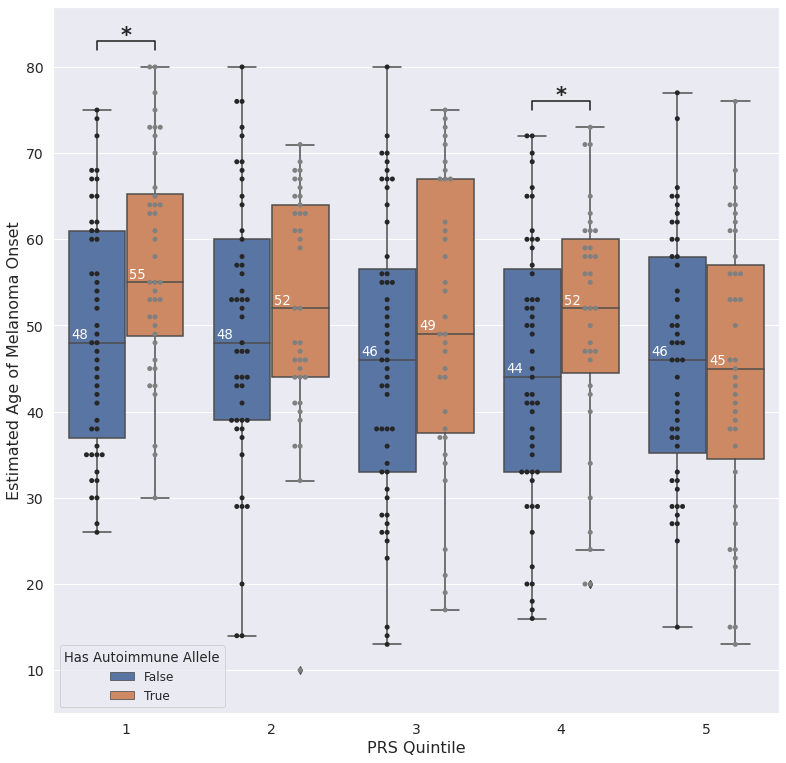

In [29]:
plt.figure(figsize=(13,13))
ax = sns.boxplot(x="PRSQuintile", y = "EstimatedAgeOfOnset", hue = "HasProtection", data = tcgaSummary)
sns.swarmplot(x="PRSQuintile", y = "EstimatedAgeOfOnset", hue = "HasProtection", data = tcgaSummary, dodge = True, color = "grey")
plt.xlabel("PRS Quintile", fontsize = 16)
plt.ylabel("Estimated Age of Melanoma Onset", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(5, 87)


handles, labels = ax.get_legend_handles_labels() #get rid of annoying double legend
ax.legend(handles[:2], labels[:2], title = "Has Autoimmune Allele", loc = 3)


#add significances:
plt.plot([-0.2,-0.2,0.2,0.2], [82, 83, 83, 82], lw = 1.5, c = 'k')
plt.text(-0.04, 83, "*", fontsize = 21, fontweight = "bold")
plt.plot([2.8,2.8,3.2,3.2], [75, 76, 76, 75], lw = 1.5, c = 'k')
plt.text(2.96, 76, "*", fontsize = 21, fontweight = "bold")

#add medians:
plt.text(-0.38, 48.5, int(quintileStats[1]["NonAIMedianAge"]), color = "white")
plt.text(0.02, 55.5, int(quintileStats[1]["AIMedianAge"]), color = "white")

plt.text(0.62, 48.5, int(quintileStats[2]["NonAIMedianAge"]), color = "white")
plt.text(1.02, 52.5, int(quintileStats[2]["AIMedianAge"]), color = "white")

plt.text(1.62, 46.5, int(quintileStats[3]["NonAIMedianAge"]), color = "white")
plt.text(2.02, 49.5, int(quintileStats[3]["AIMedianAge"]), color = "white")

plt.text(2.62, 44.5, int(quintileStats[4]["NonAIMedianAge"]), color = "white")
plt.text(3.02, 52.5, int(quintileStats[4]["AIMedianAge"]), color = "white")

plt.text(3.62, 46.5, int(quintileStats[5]["NonAIMedianAge"]), color = "white")
plt.text(4.02, 45.5, int(quintileStats[5]["AIMedianAge"]), color = "white")

In [30]:
#tcgaSummary.PRS.to_csv("../GenotypeData/TCGA_PRS.tsv", sep = "\t")

## 3. Validation (UKBB): Data Processing, Formatting, PRS Generation, Statistical Analyses, and Figures

**SNP processing and PRS construction:** 

Preprocess UKBB SNPs to remove duplicates:

In [31]:
#Generate a consistent loc between the 2 PRS files
consistentLocationIndexing = list(orData.Loc) 
prsDF["Loc"] = consistentLocationIndexing #works because the indexes between the 2 files are the same/are in the same order

#Fix the index issue where there is a bunch of superfluos text in a particular prsDF index key
print("The index SNP issue is/are: {}".format([el for el in prsDF.index if " " in el]))
newIndex = [el.split(" ")[0] if " " in el else el for el in prsDF.index]
prsDF.index = newIndex

The index SNP issue is/are: ['rs7164220 (R2=0.6 with rs4778138)']


In [32]:
#PLINK2 extracted by both RSID and CHR:LOC; How many RSIDs are there and get SNP location discrepancies with PRS Loc file
rsid = 0
ukbbLocsOffByOne = set()
for col in filteredUKBB.columns:
    if col == "ids": 
        continue
    try:
        snpLoc = col.split(":")[1].split("_")[0]
        if int(snpLoc) not in set(prsDF.Loc):
            print(snpLoc)
            ukbbLocsOffByOne.add(snpLoc)
            print(col.split(":")[1].split("_")[1])
    except:
        rsid += 1
        
        
print("PLINK2 extracted {} SNPs by RSID.".format(rsid)) #Need to check that non of the RSIDs collide with the Loc ones
print("The CHR:LOC SNPs off by one (LOC) in the UKBB are {}".format(ukbbLocsOffByOne))

15713999
T
23620688
G
42743496
T
47459379
G
PLINK2 extracted 16 SNPs by RSID.
The CHR:LOC SNPs off by one (LOC) in the UKBB are {'47459379', '42743496', '23620688', '15713999'}


In [33]:
print("If all SNPs are unique, then in total there are {} SNPs".format(filteredUKBB.shape[1] - 1))
uniqueIDs = set()
exceptChecks = 0
duplicates = set()
for col in tqdm.tqdm(filteredUKBB.columns):
    if col == "ids": 
        continue
        
    try:
        snpLoc = col.split(":")[1].split("_")[0]
        if snpLoc in ukbbLocsOffByOne:
            snpLoc = int(snpLoc) - 1
        else:
            snpLoc = int(snpLoc)
            
        #sanity check to make sure it exists/only one entry
        if prsDF[prsDF["Loc"] == snpLoc].shape[0] != 1: 
            raise ValueError("More than one SNP returned")
            break
        
        if snpLoc in uniqueIDs:
            duplicates.add(col)
        else:
            uniqueIDs.add(snpLoc)
            
    except:
        rsid = col.split("_")[0]
        snpLoc = prsDF.loc[rsid, "Loc"]
        if snpLoc in uniqueIDs:
            duplicates.add(col)
        else:
            uniqueIDs.add(snpLoc)
            
        uniqueIDs.add(snpLoc)
        exceptChecks += 1
        
print("Number RSIDs: {}".format(exceptChecks))
print("Number of unique SNPs after sanity checking is: {}".format(len(uniqueIDs)))
print("The duplicated SNPs are {}".format(duplicates))

If all SNPs are unique, then in total there are 202 SNPs


100%|██████████| 203/203 [00:00<00:00, 1879.51it/s]

Number RSIDs: 16
Number of unique SNPs after sanity checking is: 201
The duplicated SNPs are {'3:188112554_T'}


Investigate the duplicate SNP:

In [34]:
prsDF[prsDF["Loc"] == 188112554]

,Chr,Loc,Close genes in Genome Browser,"Close genes reported in Law et al., 2015",Weight#,Ref allele for the weight,CorrectedLocs
rs1464510,3.0,188112554,LPP,NaN,-0.01,A,188112554.0


In [35]:
for col in filteredUKBB.columns:
    if str(188112554) in col or "rs1464510" in col:
        print(col)

rs1464510_A
3:188112554_T


In [36]:
orData.loc["rs1464510", :]

0
Chr                      3
Loc              188112554
effect_allele            A
other_allele             C
MAF_genomel       0.448031
bet_genomel       -0.07751
P-genomel         0.000007
MAF_medit         0.417816
beta_medit       -0.002029
P-medi            0.961873
P-beta-diff       0.205498
Name: rs1464510, dtype: object

This SNP appears to have 2 minor alleles, A and T, with the main allele being C (see above). Both minor alleles are reported here. For the context of the PRS omit the T allele as it is not included in the risk score. Define a function to calculate UKBB specific PRS:

In [37]:
#Note: Rounding genotypes so results are whole numbers (0,1,2) as opposed to dosages for consistency with PRS methodology of discovery 
def Generate_UKBB_PRS(genotypeFile, referenceFile, skipThese):
    riskScores = defaultdict(float)
    locToRSID = dict(zip(referenceFile.Loc, referenceFile.index))
    flipIt = set()
    
    whereAreTheFlipIssues = list()
    #Sanity check and get the set of IDs that need to flip to 2 - number: These will be in flipIt
    for col in genotypeFile.columns:
        if (col == "ids") or (col in duplicates):
            print("Skipping col: {}".format(col))
            continue
        
        if ":" in col: #encoded as a chr:location_SNP
            #print(col)
            snpLoc = col.split(":")[1].split("_")[0]
            alleleForCount = col.split(":")[1].split("_")[1]
            if snpLoc in ukbbLocsOffByOne:
                snpLoc = int(snpLoc) - 1
            else:
                snpLoc = int(snpLoc)
                
            if alleleForCount != referenceFile.loc[locToRSID[snpLoc], "Ref allele for the weight"]:
                #print(alleleForCount)
                #print(referenceFile.loc[locToRSID[snpLoc], "Ref allele for the weight"])
                if alleleForCount != orData.loc[locToRSID[snpLoc], "other_allele"]:
                    print("ISSUES!!!")
                    
                whereAreTheFlipIssues.append(col)
                flipIt.add(col)
        
        else: #encoded as a rsid_SNP
            #print(col)
            rsid = col.split("_")[0]
            alleleForCount = col.split("_")[1]
            
            if alleleForCount != referenceFile.loc[rsid, "Ref allele for the weight"]:
                #print(alleleForCount)
                #print(referenceFile.loc[rsid, "Ref allele for the weight"])
                if alleleForCount != orData.loc[rsid, "other_allele"]:
                    print("ISSUES!!!")
                
                whereAreTheFlipIssues.append(col)
                flipIt.add(col)
    
    print("Need to flip {} SNPs for the UKBB... Calculating PRS now \n".format(len(flipIt)))
    
    for i,row in genotypeFile.iterrows():
        counter = 0 
        totalFlipped = 0
        for col in genotypeFile.columns:
            if (col == "ids") or (col in duplicates):
                continue
                
            counter +=1
            if ":" in col: #encoded as a chr:location_SNP
                snpLoc = col.split(":")[1].split("_")[0]
                if snpLoc in ukbbLocsOffByOne:
                    snpLoc = int(snpLoc) - 1
                else:
                    snpLoc = int(snpLoc)
                
                if col in flipIt:
                    riskScores[row.ids] += np.round((2 - row[col])) * referenceFile.loc[locToRSID[snpLoc], "Weight#"]
                    totalFlipped += 1
                else:
                    riskScores[row.ids] += np.round(row[col]) * referenceFile.loc[locToRSID[snpLoc], "Weight#"]
                    
            else:  #encoded as a rsid_SNP
                rsid = col.split("_")[0]
                if col in flipIt:
                    riskScores[row.ids] +=  np.round((2 - row[col])) * referenceFile.loc[rsid, "Weight#"]
                    totalFlipped += 1
                else:
                    riskScores[row.ids] += np.round(row[col]) * referenceFile.loc[rsid, "Weight#"]
                
        if counter != 201 or totalFlipped != len(flipIt):
            print("AYAYAYAY")
    
    print("SNPs which have counts for the non-effect allele and need to be flipped are:\n")
    print(whereAreTheFlipIssues)
    return riskScores

In [38]:
ukbbRiskScores = Generate_UKBB_PRS(genotypeFile = filteredUKBB, referenceFile = prsDF, skipThese = duplicates)

Skipping col: ids
Skipping col: 3:188112554_T
Need to flip 47 SNPs for the UKBB... Calculating PRS now 

SNPs which have counts for the non-effect allele and need to be flipped are:

['10:73455308_C', '10:105668843_A', '10:119572168_C', '11:6777124_T', '11:10904067_A', '11:69367118_C', '12:3554821_A', '12:17274672_C', '13:23551652_A', '13:27476285_A', '14:94597126_T', '15:24110776_C', 'rs7164220_A', '16:88096203_T', '16:89356701_G', '17:43207858_A', '18:860614_T', '18:42988088_A', '18:45709553_A', '19:3353622_T', '1:162628146_G', '1:204484617_G', '1:205163057_G', 'rs650681_C', '1:236298158_C', 'rs6088092_T', '20:35012486_G', '20:50677206_T', '20:57577935_G', '21:42743496_T', '2:38276549_G', '2:106125082_C', '2:202176294_G', '2:235749373_C', '3:28718712_A', '3:69657736_G', '4:72922675_T', '4:77204500_T', '5:33952378_C', 'rs4865588_A', '6:6405068_C', '6:7115533_A', '8:140029759_A', '9:244457_A', '9:12588950_T', 'rs10739221_C', '9:110698716_T']


**Sanity Check:** Ensure that there aren't any homozygous SNPs in the entire population - would potentially point to an issue with UKBB extracted PRS genotypes 

In [39]:
ukbbAnyEmpty = defaultdict(set)
for col in filteredUKBB.columns:
    if col == "ids" or col in duplicates:
        continue
    ukbbAnyEmpty[col] = set(filteredUKBB[col])

for k,v in ukbbAnyEmpty.items():
    if len(v) <= 1:
        print(k)
        print(v)

Map calculated PRS to summary DF:

In [40]:
ukbbComposite = ukbbRelevantIDs[['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'Age at Diagnosis', 'HasProtection', "Type"]]
ukbbComposite = ukbbComposite.rename(columns = {"Age at Diagnosis": "AgeAtDiagnosis"})
ukbbComposite["PRS"] = [ukbbRiskScores[i] for i,row in ukbbComposite.iterrows()]

Ensure all individuals are >= 20 years old:

In [41]:
ukbbComposite.shape == ukbbComposite[ukbbComposite.AgeAtDiagnosis >= 20].shape

True

### Figure generation and statistical analyses:

Do PRS correlate with age of diagnosis in the UKBB?

In [42]:
rho, pSpearman = spearmanr(ukbbComposite.PRS, ukbbComposite.AgeAtDiagnosis)
r, pPearson = pearsonr(ukbbComposite.PRS, ukbbComposite.AgeAtDiagnosis)

logging.info(f"UKBB: PRS-Age at Diagnosis Spearman Correlation: rho = {rho}   p = {pSpearman}")
logging.info(f"UKBB: PRS-Age at Diagnosis Pearson Correlation: r = {r}   p = {pPearson}")

UKBB: PRS-Age at Diagnosis Spearman Correlation: rho = 0.051657161052272214   p = 0.42664585829607915
UKBB: PRS-Age at Diagnosis Pearson Correlation: r = 0.02419904639844187   p = 0.70974295121776


Do PRS associate significantly with an earlier age of diganosis in validation set (UKBB)?

In [43]:
ukbbModel= smf.ols(formula='AgeAtDiagnosis ~ PRS', data = ukbbComposite).fit() 
summary = ukbbModel.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.2842,0.948,59.342,0.000,54.416,58.153
PRS,0.7551,2.026,0.373,0.710,-3.237,4.747


Do melanoma PRS and MHC-I AI allele genotype interact?

In [44]:
ukbbModelInteraction = smf.ols(formula='AgeAtDiagnosis ~ HasProtection*PRS', data=ukbbComposite).fit() #*zWinnersCurse
summary = ukbbModelInteraction.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,55.2248,1.196,46.187,0.000,52.869,57.580
HasProtection[T.True],2.8137,1.964,1.432,0.153,-1.056,6.684
PRS,1.7785,2.508,0.709,0.479,-3.163,6.720
HasProtection[T.True]:PRS,-2.8777,4.252,-0.677,0.499,-11.254,5.498


**Figure 2C:**

(17.0, 93.0)

<Figure size 1296x1296 with 0 Axes>

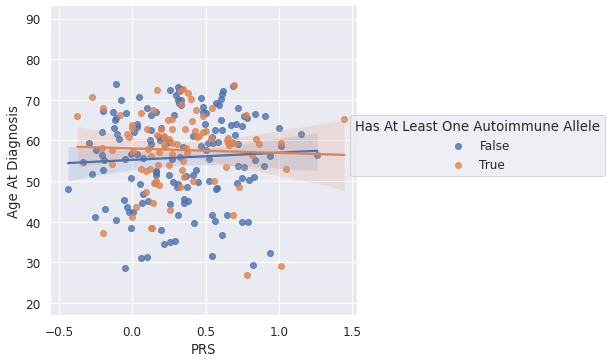

In [45]:
plt.figure(figsize=(18,18))
g = sns.lmplot(data = ukbbComposite, y="AgeAtDiagnosis", x = "PRS", hue="HasProtection", legend_out=False) 
plt.xlabel("PRS") 

plt.legend(bbox_to_anchor=(1.83, .43), title='Has At Least One Autoimmune Allele', loc='lower right') 
plt.ylabel("Age At Diagnosis")
plt.xlim(-0.56, 1.53)
plt.ylim(17,93)

**Supplementary Figure 11C:** Histogram of PRS stratified across individuals with and without MHC-I AI alleles (Validation - UKBB)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

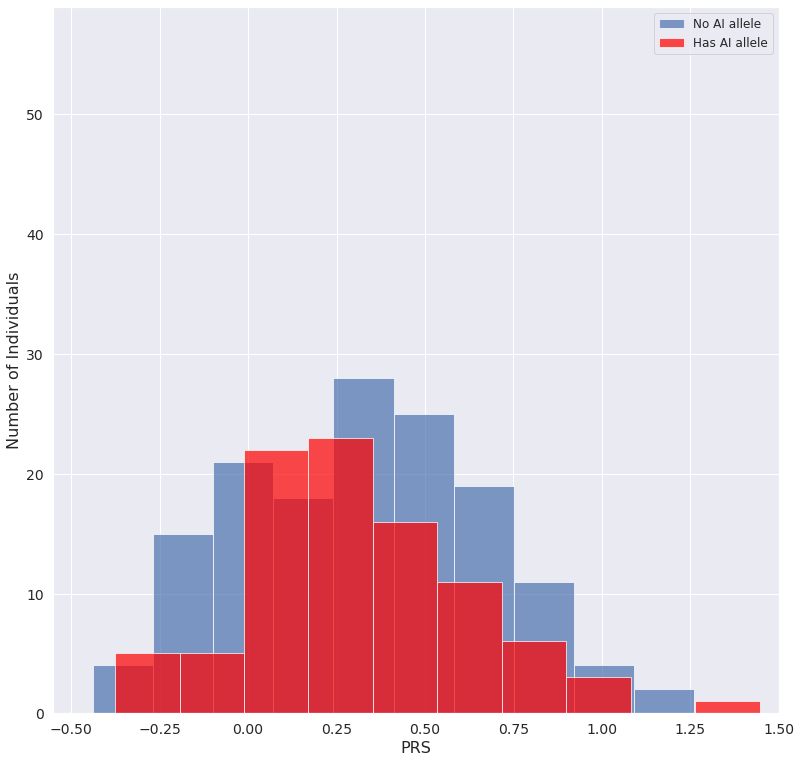

In [46]:
plt.figure(figsize=(13,13))
plt.hist(ukbbComposite[ukbbComposite["HasProtection"]==False].PRS, alpha = 0.7, label="No AI allele")
plt.hist(ukbbComposite[ukbbComposite["HasProtection"]].PRS, alpha = 0.7, label = "Has AI allele", color= "red")
plt.legend()

plt.xlabel("PRS", fontsize = 16)
plt.ylabel("Number of Individuals", fontsize = 16)
plt.xlim(-0.55, 1.5)
plt.ylim(0,59)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)

**Supplementary Figure 11D:** Box + swarm plots stratifying PRS across individuals with and without MHC-I AI alleles (Validation - UKBB)



Statistic = -0.124, p= 0.901
Same distribution (fail to reject H0)


(array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
         1.5 ,  1.75]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

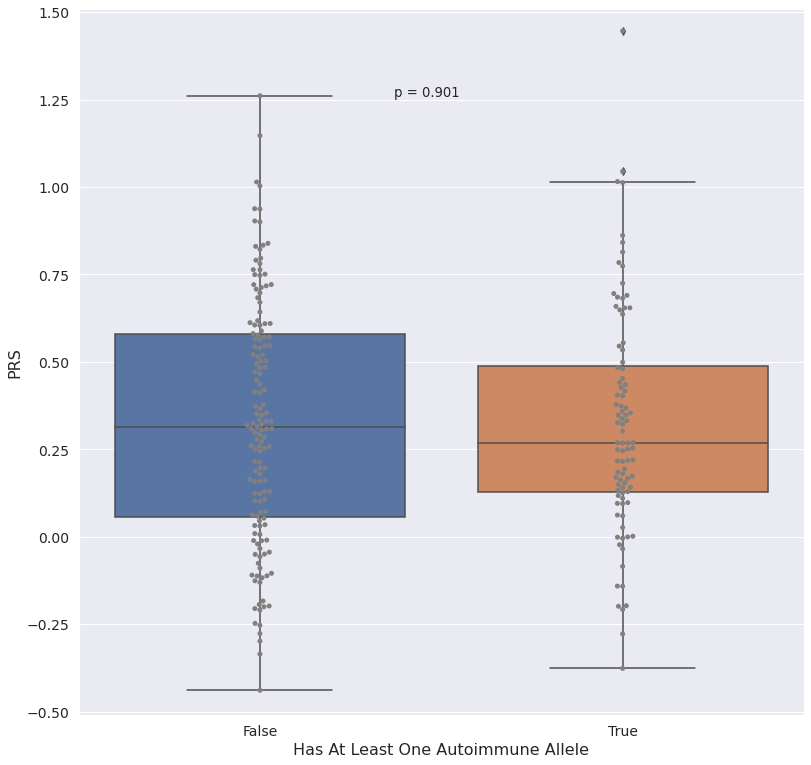

In [47]:
stat,pPRSDiff = ttest_ind(ukbbComposite[ukbbComposite["HasProtection"]].PRS, ukbbComposite[ukbbComposite["HasProtection"]==False].PRS)

print("\n")
print('Statistic = %.3f, p= %.3f' % (stat, pPRSDiff))

alpha = 0.05
if pPRSDiff > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

plt.figure(figsize=(13,13))
sns.boxplot(data = ukbbComposite, y = "PRS", x = "HasProtection")
sns.swarmplot(data = ukbbComposite, y = "PRS", x = "HasProtection", color = 'grey')

plt.text(0.37, 1.26, "p = {0:.3f}".format(pPRSDiff)) #(T-Test)
plt.xlabel("Has At Least One Autoimmune Allele", fontsize = 16)
plt.ylabel("PRS", fontsize = 16)
plt.ylim(-0.51, 1.51)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)